# Reproducing main results

This notebook reproduces the main results reported in for semi-supervised learning on the QM9 dataset.

In [ ]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from omegaconf import OmegaConf

sys.path.append(os.path.join(os.getcwd(), "src"))

from src.models import DimeNetPPModel 
from src.qm9 import QM9DataModule

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cpu


In [ ]:
MODEL_PATH = "model.pt" 

if not os.path.exists(MODEL_PATH):
    print(f"Error: Could not find model at {MODEL_PATH}")
else:
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    print("Checkpoint loaded successfully.")
    print("Keys available:", checkpoint.keys())
    
    data_mean = checkpoint["data_mean"].to(device)
    data_std = checkpoint["data_std"].to(device)
    print(f"Data Mean: {data_mean.item():.4f}, Data Std: {data_std.item():.4f}")

Checkpoint loaded successfully.
Keys available: dict_keys(['state_dict', 'model_config', 'data_mean', 'data_std'])
Data Mean: -6.5378, Data Std: 0.6049


/tmp/ipykernel_3526382/2720035690.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


In [ ]:
model_config = checkpoint["model_config"]

model_config.pop("_target_", None)
model_config.pop("_partial_", None)

print(f"Initializing model with config: {model_config}")

model = DimeNetPPModel(**model_config)

model.load_state_dict(checkpoint["state_dict"])
model.to(device)
model.eval()

print("Model successfully loaded and moved to device.")

Initializing model with config: {'num_node_features': 11, 'hidden_channels': 128, 'out_channels': 1, 'num_blocks': 4, 'int_emb_size': 64, 'basis_emb_size': 8, 'out_emb_channels': 64, 'num_spherical': 7, 'num_radial': 6, 'cutoff': 5.0, 'max_num_neighbors': 32, 'num_before_skip': 1, 'num_after_skip': 2, 'num_output_layers': 3, 'act': 'swish', 'output_initializer': 'zeros', 'pretrained': True}
Model successfully loaded and moved to device.


In [ ]:
TARGET_IDX = 2 

dm = QM9DataModule(
    target=TARGET_IDX,
    data_dir="./data",  
    batch_size_inference=128,
    num_workers=0,      
    seed=0             
)

dm.prepare_data()
dm.setup()

test_loader = dm.test_dataloader()
print(f"Test loader ready with {len(test_loader.dataset)} samples.")

Normalizing targets: Mean=-6.5378, Std=0.6049
QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=32, unlabeled=32
Normalizing targets: Mean=-6.5378, Std=0.6049
QM9 dataset loaded with 10466 labeled, 94198 unlabeled, 13083 validation, and 13084 test samples.
Batch sizes: labeled=32, unlabeled=32
Test loader ready with 13084 samples.


In [ ]:
all_preds = []
all_targets = []

print("Running inference on Test Set...")

with torch.no_grad():
    for batch_data in tqdm(test_loader):
        if isinstance(batch_data, (tuple, list)):
            batch, targets = batch_data
        else:
            batch = batch_data
            targets = batch.y

        batch = batch.to(device)
        
        pred_norm = model(batch)
        
        pred_real = (pred_norm * data_std) + data_mean
        
        all_preds.append(pred_real.cpu())
        all_targets.append(targets.cpu())

all_preds = torch.cat(all_preds).numpy().flatten()
all_targets = torch.cat(all_targets).numpy().flatten()

mae = np.mean(np.abs(all_preds - all_targets))
mse = np.mean((all_preds - all_targets)**2)

print("="*30)
print(f"Final Test MAE: {mae:.4f}")
print(f"Final Test MSE: {mse:.4f}")
print("="*30)

Running inference on Test Set...


100%|██████████| 103/103 [03:58<00:00,  2.31s/it]

Final Test MAE: 0.0775
Final Test MSE: 0.0133


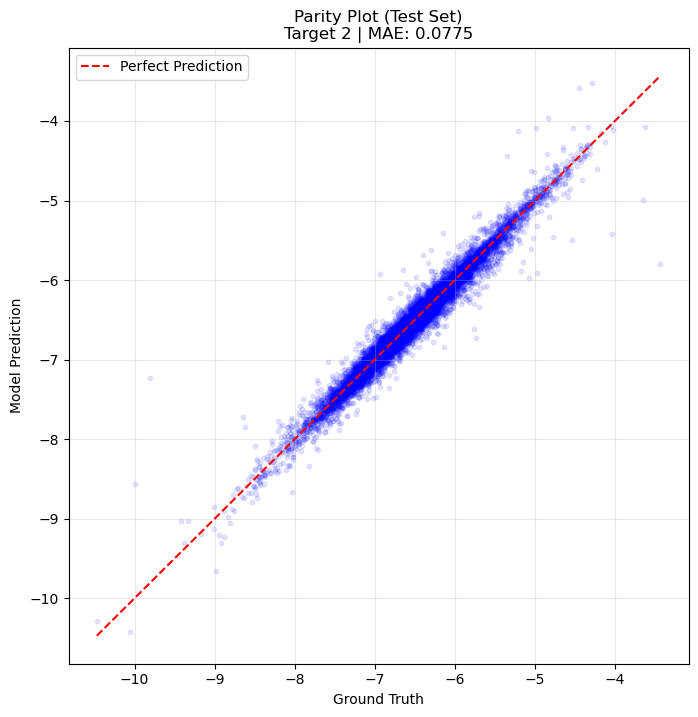

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(all_targets, all_preds, alpha=0.1, s=10, color='blue')

min_val = min(all_targets.min(), all_preds.min())
max_val = max(all_targets.max(), all_preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.title(f"Parity Plot (Test Set)\nTarget {TARGET_IDX} | MAE: {mae:.4f}")
plt.xlabel("Ground Truth")
plt.ylabel("Model Prediction")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()